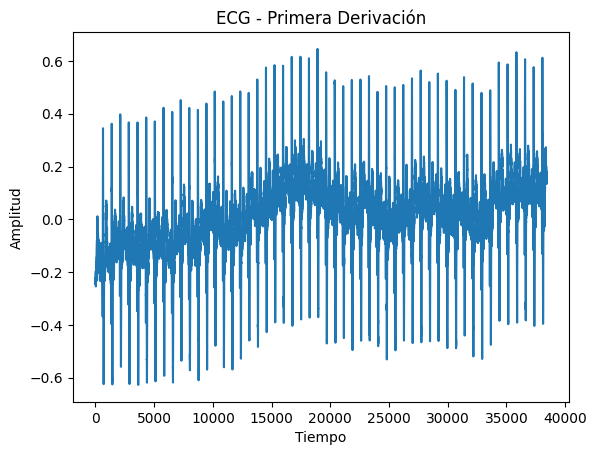

In [10]:
import wfdb
import matplotlib.pyplot as plt

# Ruta al archivo SIN extensión (ejemplo: "ecg_data/record_001")
record_name = "s0010_re"

# Cargar el ECG
record = wfdb.rdrecord(record_name)
signal = record.p_signal

# Graficar la señal ECG
plt.plot(signal[:, 0])  # Graficamos la primera derivación
plt.title("ECG - Primera Derivación")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.show()

In [3]:
import wfdb
import numpy as np
import pandas as pd
import glob
from scipy.signal import resample